In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import math
import logging
import os
import copy
import math
import pathlib
from datetime import datetime
import csv
import json

# Japanese compatible font
plt.rcParams['font.sans-serif'] = "Microsoft YaHei" 

# Computation device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using device: CPU")

Using device: NVIDIA GeForce GTX 1060 6GB


In [9]:
K_DATASET_DIR = os.path.join('dataset', 'Kuzushiji-49')
K_DATASET_TRAIN_X_FILE = 'k49-train-imgs.npz'
K_DATASET_TRAIN_Y_FILE = 'k49-train-labels.npz'
K_DATASET_CLASSMAP = 'k49_classmap.csv'

k_train_images = torch.tensor(np.load(os.path.join(os.getcwd(), K_DATASET_DIR, K_DATASET_TRAIN_X_FILE))['arr_0'], dtype=torch.float32)
k_train_labels = torch.tensor(np.load(os.path.join(os.getcwd(), K_DATASET_DIR, K_DATASET_TRAIN_Y_FILE))['arr_0'], dtype=torch.int64)
print(f"Training Set: Input shape: {train_images.shape}. Output shape: {train_labels.shape}")

k_class_map = pd.read_csv(os.path.join(os.getcwd(), K_DATASET_DIR, K_DATASET_CLASSMAP))

Training Set: Input shape: torch.Size([232365, 28, 28]). Output shape: torch.Size([232365])


In [10]:
k_class_map

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


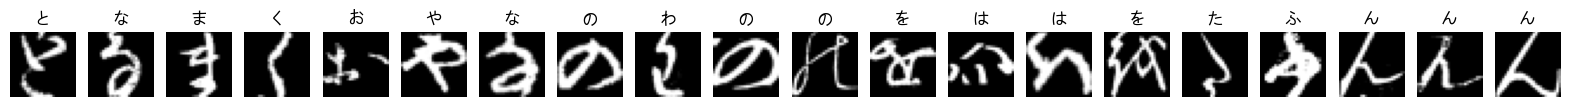

In [8]:
figure = plt.figure(figsize=(20, 5))
for i in range(1, 21):
    img = k_train_images[i]
    label = k_train_labels[i]
    figure.add_subplot(1, 20, i)
    plt.title(k_class_map['char'][int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [36]:
idx_map = torch.zeros((5*49), dtype=torch.int64)

In [33]:
for class_no in range(49):
    mask = (k_train_labels == class_no)
    idxs = torch.nonzero(mask).reshape((-1,))
    idx_map[class_no * 5 : class_no * 5 + 5] = idxs[:5]

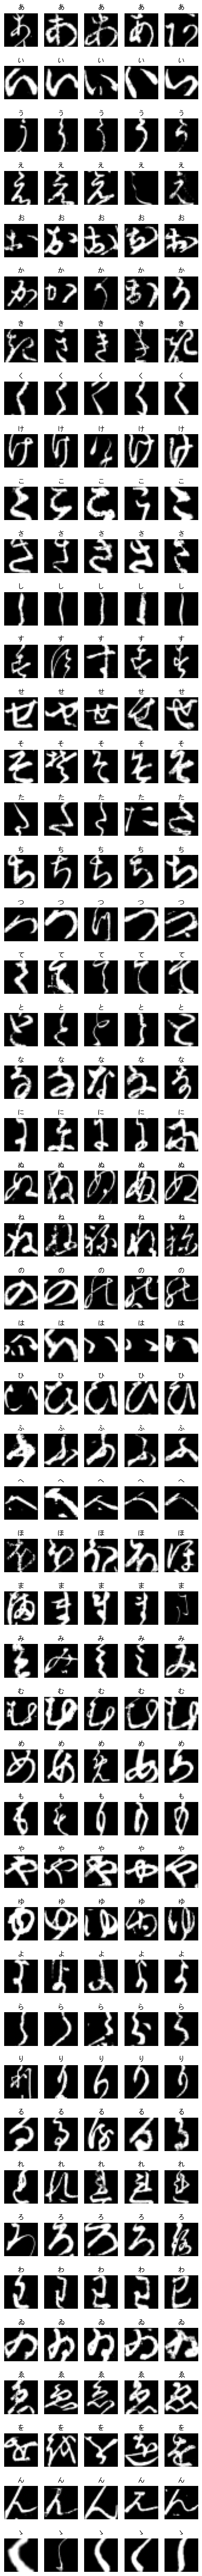

In [32]:
figure = plt.figure(figsize=(6, 5*16))
for class_no in range(49):
    for i in range(5):
        idx = idx_map[class_no*5 + i]
        img = k_train_images[idx]
        label = k_train_labels[idx]
        figure.add_subplot(49, 5, class_no*5 + i+1)
        plt.title(k_class_map['char'][int(label)])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [41]:
def getETLDataset():
    DATASET_DIR = os.path.join('dataset','ETL_8B')
    DATASET_TRAIN_FILE = 'ETL8B2C1.csv'
    train_labels = []
    train_images = []
    with open(os.path.join(DATASET_DIR, DATASET_TRAIN_FILE), 'r') as csv_file:
        csvreader = csv.reader(csv_file)
        for data in csvreader:
            train_labels.append(int(data[0]))
            train_images.append([int(a) for a in data[1:]])
    train_images = torch.tensor(train_images, dtype=torch.float32).reshape(-1,32,32)
    train_labels = torch.tensor(train_labels, dtype=torch.int64)

    # Add one dimension for channel
    train_images = train_images.unsqueeze(1)
    print(f"Training Set: Input shape: {train_images.shape}")

    print(f"Max pixel value: {train_images.max()}, min: {train_images.min()}")

    # shift pixel values into [0,255]
    def shiftInputImage(images):
        return images * 255
        
    train_images = shiftInputImage(train_images)
    print(f"transformed: Max pixel value: {train_images.max()}, min: {train_images.min()}")

    torch.cuda.empty_cache() 

    return train_images, train_labels, None, None

In [42]:
h_train_images, h_train_labels, _, _ = getETLDataset()

Training Set: Input shape: torch.Size([7360, 1, 32, 32])
Max pixel value: 1.0, min: 0.0
transformed: Max pixel value: 255.0, min: 0.0


In [43]:
idx_map = torch.zeros((5*40), dtype=torch.int64)
for class_no in range(40):
    mask = (h_train_labels == class_no)
    idxs = torch.nonzero(mask).reshape((-1,))
    idx_map[class_no * 5 : class_no * 5 + 5] = idxs[:5]

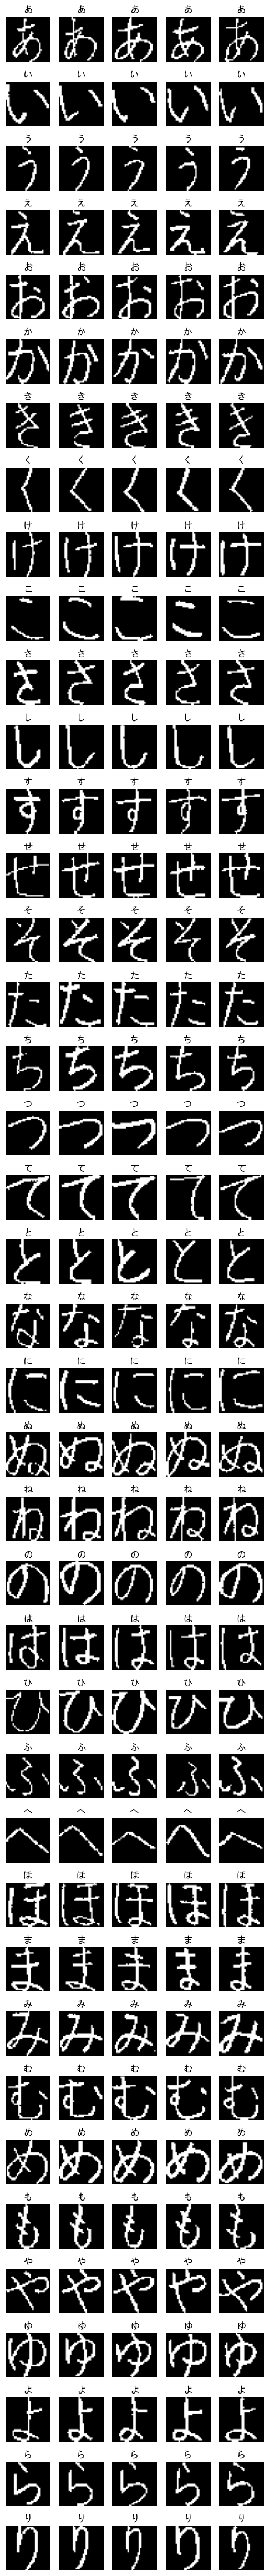

In [45]:
figure = plt.figure(figsize=(6, 5*12))
for class_no in range(40):
    for i in range(5):
        idx = idx_map[class_no*5 + i]
        img = h_train_images[idx]
        label = h_train_labels[idx]
        figure.add_subplot(40, 5, class_no*5 + i+1)
        plt.title(k_class_map['char'][int(label)])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Generator

In [65]:
import logging
import os
import copy
import math
import pathlib
from datetime import datetime
import csv
import json

# 3rd Party
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

class Diffusion:
    def __init__(self, noise_step=1000, beta_start=1e-4, beta_end=0.02, img_size=64):
        self.noise_step = noise_step
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_step)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).reshape(t.shape[0], 1, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t]).reshape(t.shape[0], 1, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        Ɛ = torch.randn_like(x)
        return (
            (torch.mul(sqrt_alpha_hat, x)+torch.mul(sqrt_one_minus_alpha_hat,Ɛ)),
            Ɛ
        )

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_step, size=(n,))

    # denoise process
    def sample(self, model, n, labels, cfg_scale=3, name="sampling-demo"):
        pathlib.Path(f'demo_imgs/{name}').mkdir(parents=True, exist_ok=True) 
        logging.info(f"Sampling {n} new images ...")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(device)
            # for i in tqdm( reversed(range(1, self.noise_step)), position=0):
            for i in reversed(range(1, self.noise_step)):
                t_tensor = (torch.ones(n) * i).long().to(device)
                t = i
                predicted_noise = model(x, t_tensor, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t_tensor, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t]
                alpha_hat = self.alpha_hat[t]
                beta = self.beta[t]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    # in the final iteration, we don't want to add noise back to X0
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                x_ = (x.clamp(-1, 1) + 1) / 2
                x_ = (x_ * 255).type(torch.uint8)
                save_images(x_, os.path.join("demo_imgs", f"{name}", f"{(self.noise_step - i)}.jpg"))

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class UNet_Conditional(nn.Module):
    # sf: scaling factor of cnn kernel numbers
    def __init__(self, c_in=1, c_out=1, time_dim=256, num_classes=None, sf=16):
        super().__init__()
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, sf*1)
        self.down1 = Down(sf*1, sf*2)
        self.sa1 = SelfAttention(sf*2, 16)
        self.down2 = Down(sf*2, sf*4)
        self.sa2 = SelfAttention(sf*4, 8)
        self.down3 = Down(sf*4, sf*4)
        self.sa3 = SelfAttention(sf*4, 4)

        self.bot = DoubleConv(sf*4, sf*4)

        self.up1 = Up(sf*4+sf*4, sf*2)
        self.sa4 = SelfAttention(sf*2, 8)
        self.up2 = Up(sf*2+sf*2, sf*1)
        self.sa5 = SelfAttention(sf*1, 16)
        self.up3 = Up(sf*1+sf*1, sf*1)
        self.sa6 = SelfAttention(sf*1, 32)
        self.outc = nn.Conv2d(sf*1, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    # y: labels (the condition of diffusion)
    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [48]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, nrow=4, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [66]:
CLASS_NUM = 49
model = UNet_Conditional(c_in=1, c_out=1, num_classes=CLASS_NUM, sf=8).to(device)
model.load_state_dict(torch.load(os.path.join("results", "ELB_5e5_t200_continued_1", "model_epoch_100.pt")))
diffusion = Diffusion(img_size=32, noise_step=200)

In [69]:
labels = torch.tensor([4, 25, 37, 2],dtype=torch.int64).to(device)
# .long()
torch.cuda.empty_cache()
sampled_images = diffusion.sample(model, n=len(labels), labels=labels, name='goodmorning')
# save_images(sampled_images, os.path.join("results", f"{name}", f"{(epoch * train_total_step + i)}.jpg"))
